In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

seed(10)
set_random_seed(10)

Using TensorFlow backend.


In [4]:
df = pd.read_csv('data/sensor.csv', index_col=0)
df.head()
# df.shape

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [5]:
## 데이터 Type 변경
df['date'] = pd.to_datetime(df['timestamp'])



for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')
del df['timestamp']

## 날짜로 sorting
df = df.set_index('date')
df = df.reset_index()

# column을 리스트로 변환시켜서 index 로 만들거임
labels = df['date'].tolist()
df.index = labels
# del df['date']

# ## 결측 변수 확인
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

## 중복된 데이터를 삭제합니다.
df = df.drop_duplicates()
## 센서 15번, 센서 50 은 삭제합
del df['sensor_15']
del df['sensor_50']

## 이전 시점의 데이터로 보간
df = df.fillna(method='ffill')


### 나중에 사용할수 있도록 시간축을 추가함
df_data = df['date']
del df['date']

df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


In [7]:
df_data.head()

2018-04-01 00:00:00   2018-04-01 00:00:00
2018-04-01 00:01:00   2018-04-01 00:01:00
2018-04-01 00:02:00   2018-04-01 00:02:00
2018-04-01 00:03:00   2018-04-01 00:03:00
2018-04-01 00:04:00   2018-04-01 00:04:00
Name: date, dtype: datetime64[ns]

In [8]:
# 데이터 분리
normal_df = df[df['machine_status']=='NORMAL']
del normal_df['machine_status']
abnormal_df = df[df['machine_status']!='NORMAL']
del abnormal_df['machine_status']

In [9]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(normal_df)
X_test = scaler.transform(abnormal_df)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (205836, 1, 50)
Test data shape: (14484, 1, 50)


In [10]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model


# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             4288      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 50)             850 

In [11]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 195544 samples, validate on 10292 samples
Epoch 1/100
195544/195544 [==============================] - 228s 1ms/step - loss: 0.0440 - val_loss: 0.0434
Epoch 2/100
195544/195544 [==============================] - 240s 1ms/step - loss: 0.0355 - val_loss: 0.0402
Epoch 3/100
195544/195544 [==============================] - 237s 1ms/step - loss: 0.0341 - val_loss: 0.0370
Epoch 4/100
195544/195544 [==============================] - 233s 1ms/step - loss: 0.0334 - val_loss: 0.0369
Epoch 5/100
195544/195544 [==============================] - 229s 1ms/step - loss: 0.0331 - val_loss: 0.0366
Epoch 6/100
195544/195544 [==============================] - 230s 1ms/step - loss: 0.0330 - val_loss: 0.0354
Epoch 7/100
195544/195544 [==============================] - 229s 1ms/step - loss: 0.0327 - val_loss: 0.0356
Epoch 8/100
195544/195544 [==============================] - 229s 1ms/step - loss: 0.0325 - val_loss: 0.0362
Epoch 9/100
195544/195544 [==============================] - 229s 1ms/step - 

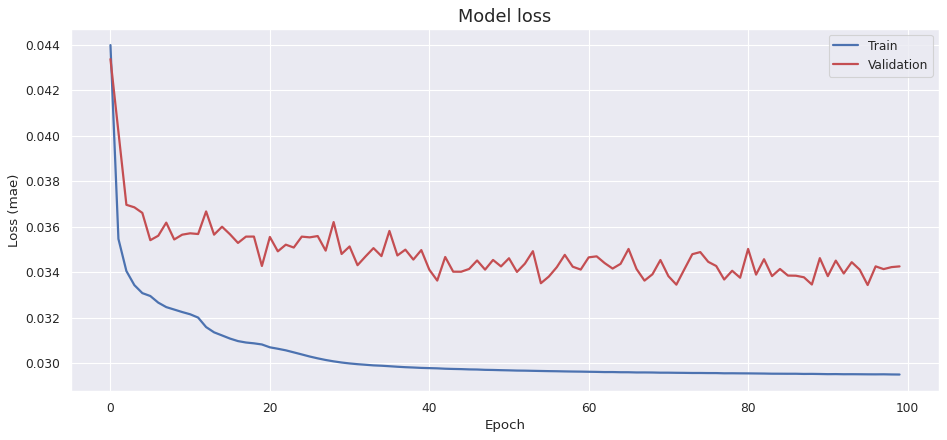

In [12]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


평균 :  0.029897818297776862
중간값 :  0.025542465122996703
최대 :  0.21052015270219196
최소 :  0.00619373606331323


/home/rain/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

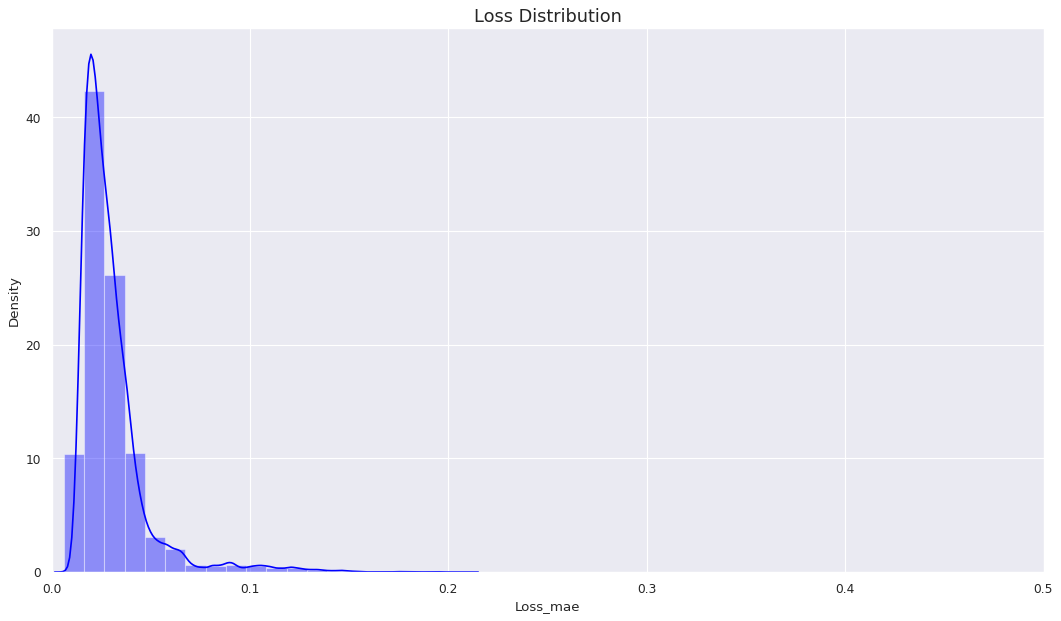

In [96]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=normal_df.columns)
X_pred.index = normal_df.index

scored = pd.DataFrame(index=normal_df.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
print('평균 : ', np.mean(scored['Loss_mae']))
print('중간값 : ', np.median(scored['Loss_mae']))
print('최대 : ', np.max(scored['Loss_mae']))
print('최소 : ', np.min(scored['Loss_mae']))
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue', label='Train')
plt.xlim([0.0,.5])

평균 :  0.18401638397711842
중간값 :  0.19953165697846678
최대 :  0.5235625210494761
최소 :  0.02547741095019332


/home/rain/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

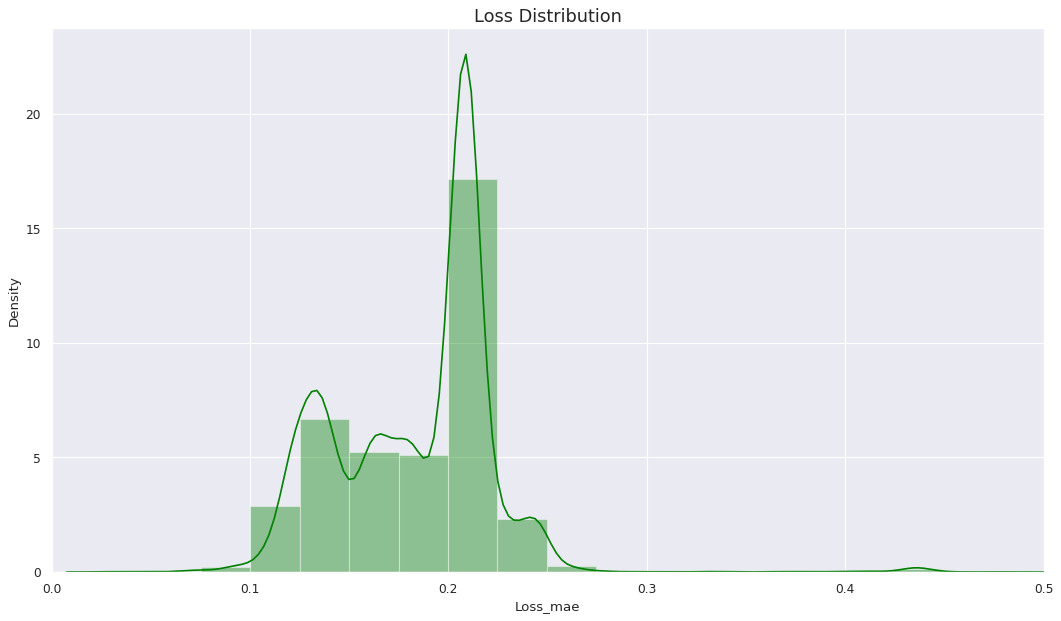

In [95]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=abnormal_df.columns)
X_pred.index = abnormal_df.index

scored = pd.DataFrame(index=abnormal_df.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
# 모든 센서들의 값에 예측값들 간의 차이를 보고 평균을 내려서 확인
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
print('평균 : ', np.mean(scored['Loss_mae']))
print('중간값 : ', np.median(scored['Loss_mae']))
print('최대 : ', np.max(scored['Loss_mae']))
print('최소 : ', np.min(scored['Loss_mae']))
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'green', label='Test')
plt.xlim([0.0,.5])

# scored['Threshold'] = 0.2
# scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
# scored.head()


/home/rain/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/rain/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Normal,Abnormal
평균,0.029898,0.184016
중간값,0.025542,0.199532
최대,0.210520,0.523563
최소,0.006194,0.025477


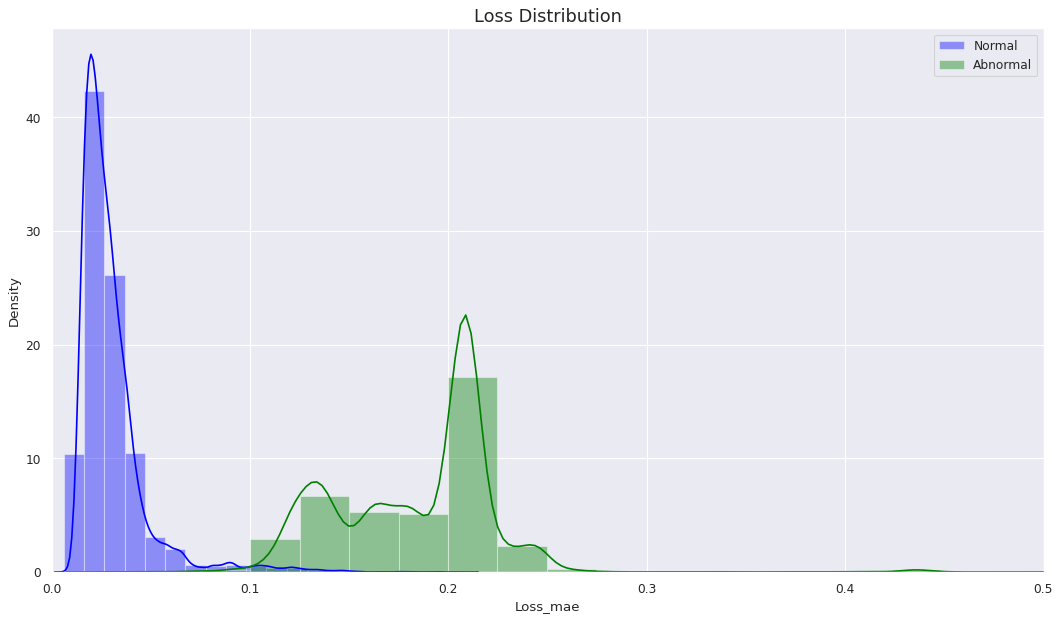

In [100]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=normal_df.columns)
X_pred.index = normal_df.index

# 비교표 만들기
compare_table = pd.DataFrame(index=['평균', '중간값', '최대', '최소'])

scored_train = pd.DataFrame(index=normal_df.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
compare_table['Normal'] = [np.mean(scored_train['Loss_mae']),np.median(scored_train['Loss_mae']),np.max(scored_train['Loss_mae']),np.min(scored_train['Loss_mae'])]

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored_train['Loss_mae'], bins = 20, kde= True, color = 'blue', label='Normal')
plt.xlim([0.0,.5])


# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=abnormal_df.columns)
X_pred.index = abnormal_df.index

scored_test = pd.DataFrame(index=abnormal_df.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
# 모든 센서들의 값에 예측값들 간의 차이를 보고 평균을 내려서 확인
scored_test['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
compare_table['Abnormal'] = [np.mean(scored_test['Loss_mae']),np.median(scored_test['Loss_mae']),np.max(scored_test['Loss_mae']),np.min(scored_test['Loss_mae'])]

sns.distplot(scored_test['Loss_mae'], bins = 20, kde= True, color = 'green', label='Abnormal')
plt.legend(loc='upper right')
plt.xlim([0.0,.5])

compare_table

threshold_70 :  0.15570328706790504
threshold_80 :  0.1516585589380174
threshold_90 :  0.1476138308081298
threshold_100 :  0.14356910267824216


,Normal,Abnormal
평균,0.029898,0.184016
중간값,0.025542,0.199532
최대,0.210520,0.523563
최소,0.006194,0.025477


In [192]:
scored_train.head()

,Loss_mae
2018-04-01 00:00:00,0.025676
2018-04-01 00:01:00,0.025676
2018-04-01 00:02:00,0.024369
2018-04-01 00:03:00,0.024212
2018-04-01 00:04:00,0.022643


In [320]:
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

# 데이터 concat 시키고 시간별로 sort
scored = pd.concat([scored_train, scored_test])
scored.sort_index()

def gauss_n_threshold(score, score_ab, num_g, num_th, viz):
    # score : total data
    # score_ab : abnomal data
    # num_g : gaussinan sigma size
    # num_th : threshold %
    # viz : visualize or not

    ## 가우시안 커널 적용
    if num_g == 0:
        score_g = score
    else:
        score_g = pd.DataFrame(index=score.index)
        score_g['Loss_mae'] = gaussian_filter1d(score['Loss_mae'], num_g)

    ## Z-score 기반 abnormal 데이터의 하위 70% 에 대해서 threshold 적용
    abn_std = np.std(score_ab['Loss_mae'])
    abn_mean = np.mean(score_ab['Loss_mae'])
    thre = (-num_th/100*abn_std)+abn_mean

    score_g['Threshold'] = thre
    score_g['Anomaly'] = score_g['Loss_mae'] > score_g['Threshold']

    if viz == True:
        viz_plot(score_g, num_g, num_th)
    else:
        return score_g

## 시각화 하기
def viz_plot(score, num_g, num_th):
    ax = score.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])
    
    ax.set_title(f'Gauss_ker: sigma_{num_g}, threshold : -{num_th}%', fontsize=16)
    ## 불량 구간 탐색 데이터
    labels = df['machine_status'].values.tolist()
    dates = df.index

    ## 고장구간 표시
    temp_start = dates[0]
    temp_date = dates[0]
    temp_label = labels[0]

    for xc, value in zip(dates, labels):
        if temp_label != value:
            if temp_label == "BROKEN":
                ax.axvspan(temp_start, temp_date, alpha=0.2, color='green')
            if temp_label == "RECOVERING":
                ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
            temp_start=xc
            temp_label=value
        temp_date = xc
    if temp_label == "BROKEN":
        ax.axvspan(temp_start, xc, alpha=0.2, color='green')
    if temp_label == "RECOVERING":
        ax.axvspan(temp_start, xc, alpha=0.2, color='orange')
    
    new_df = pd.DataFrame(index=dates)
    new_df['status'] = labels
    new_df.replace('NORMAL',False, inplace=True)
    new_df.replace('BROKEN', True, inplace=True)
    new_df.replace('RECOVERING', True, inplace=True)

    

    conf_mat = confusion_matrix(new_df['status'],score['Anomaly'])
    acc = accuracy_score(new_df['status'],score['Anomaly'])
    pre = precision_score(new_df['status'],score['Anomaly'])
    rec = recall_score(new_df['status'],score['Anomaly'])

    print('confusion_matrix : ', conf_mat)
    print('accuracy_score : ', acc)
    print('precision_score : ', pre)
    print('recall_score : ', rec)
    
    # print(classification_report(new_df['status'],score['Anomaly'], target_names=['reconstruct', 'GT']))


confusion_matrix :  [[195831  10005]
 [ 14460     24]]
accuracy_score :  0.8889569716775599
precision_score :  0.0023930601256356566
recall_score :  0.0016570008285004142


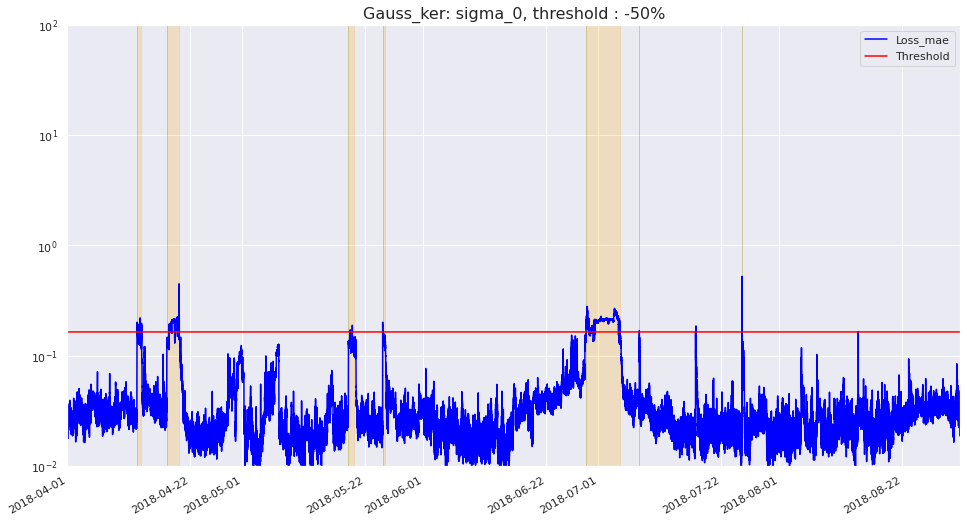

In [323]:
gauss_n_threshold(scored, scored_test, num_g=0, num_th=50, viz=True)

confusion_matrix :  [[194882  10954]
 [ 14458     26]]
accuracy_score :  0.8846586782861293
precision_score :  0.0023679417122040073
recall_score :  0.0017950842308754487


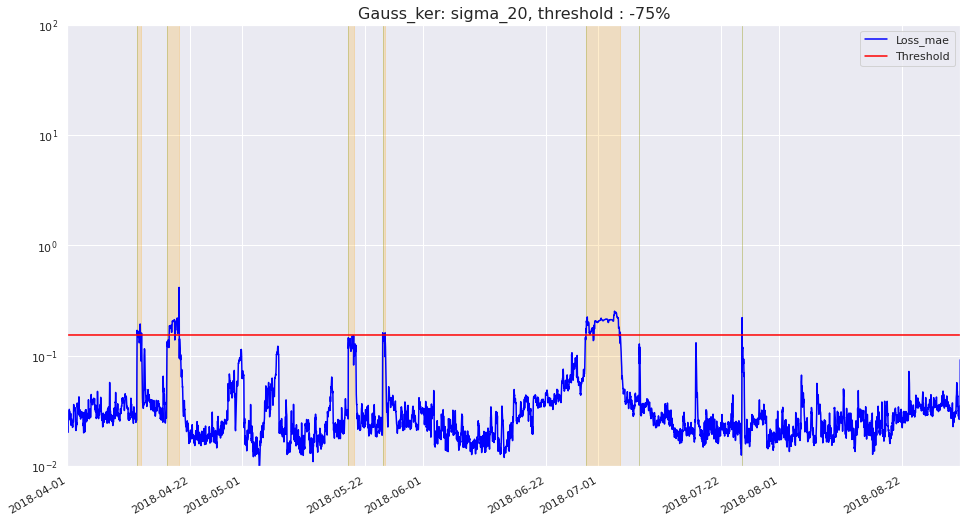

In [328]:
gauss_n_threshold(scored, scored_test, num_g=20, num_th=75, viz=True)

In [ ]:
num_g=0, num_th=50
confusion_matrix :  
[[195831  10005]
 [ 14460     24]]
accuracy_score :  0.8889569716775599
precision_score :  0.0023930601256356566
recall_score :  0.0016570008285004142

num_g=10, num_th=50
confusion_matrix :  
[[195857   9979]
 [ 14459     25]]
accuracy_score :  0.8890795206971678
precision_score :  0.002499000399840064
recall_score :  0.0017260425296879314

num_g=20, num_th=50
confusion_matrix :  
[[195872   9964]
 [ 14484      0]]
accuracy_score :  0.889034132171387
precision_score :  0.0
recall_score :  0.0

num_g=0, num_th=75
confusion_matrix :  
[[194939  10897]
 [ 14449     35]]
accuracy_score :  0.8849582425562817
precision_score :  0.0032016099524332237
recall_score :  0.002416459541563104

num_g=10, num_th=75
confusion_matrix :  
[[194846  10990]
 [ 14448     36]]
accuracy_score :  0.8845406681190995
precision_score :  0.0032650099764193726
recall_score :  0.0024855012427506215

num_g=20, num_th=75
confusion_matrix :  
[[194882  10954]
 [ 14458     26]]
accuracy_score :  0.8846586782861293
precision_score :  0.0023679417122040073
recall_score :  0.0017950842308754487